# Simulated Aberration Recovery  
## Parameter Estimation
Gautam Gunjala  
UC Berkeley Computational Imaging Lab  
05/2018

In [1]:
import numpy                 as np
import numpy.fft             as nf
import scipy                 as sp
import matplotlib.pyplot     as plt
import matplotlib.image      as mpimg
import imgUtil               as iu
import mathUtil              as mu
import calibrationUtil       as cu
import plotUtil              as pu

from scipy                   import special
from scipy                   import optimize
from scipy                   import io
from scipy                   import ndimage

## Load dataset

In [2]:
tmp     = sp.io.loadmat("test_rand_0.25.mat")

meas    = np.squeeze(tmp["meas"])
pupDom  = np.squeeze(tmp["pupDom"])
Pupil   = np.squeeze(tmp["Pupil"])
phiEst  = np.squeeze(tmp["phiEst"])
nFx     = np.squeeze(tmp["nFx"])
nFy     = np.squeeze(tmp["nFy"])
fc      = np.squeeze(tmp["fc"])
NA      = np.squeeze(tmp["NA"])
ps      = np.squeeze(tmp["ps"])
lam     = np.squeeze(tmp["lam"])
U       = np.squeeze(tmp["U"])
V       = np.squeeze(tmp["V"])
coef    = tmp["coef"]
raylMu  = np.squeeze(tmp["raylMu"])

## Compute Measurement Spectra

In [3]:
maxD    = 5
nimg    = 4
nx,ny   = meas.shape[1:3]
cpix    = int(np.ceil(nx/2))
Z       = mu.zernikeStandardBasisConversion(maxD)

IuMag   = np.zeros((nimg,nx,ny))
for i in np.arange(nimg):
    IuMag[i] = iu.rmvDC(0.5*np.abs(iu.fft2c(meas[i]))/phiEst)[0]

## Estimate Illumination Angles  
Needs work, using true angles + noise for now.

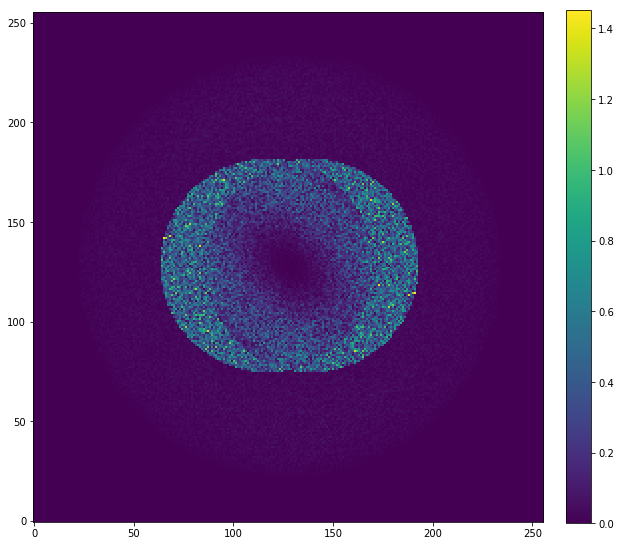

In [7]:
plt.figure(figsize=(10,10))
pu.imagesc(IuMag[1],axis="xy",cbar=1)

In [12]:
radP    = nx*ps*fc
ndfx    = 1/radP
print(radP)
print(nx)
up,vp   = cu.findCirc(IuMag[1],radP)

up2,vp2 = cu.findCircleCenter(IuMag[1],radP,(up,vp),0.5)




53.67088607594937
256


In [14]:
print(up2*ndfx)
print(vp2*ndfx)

print(U)
print(V)

print(radP)




0.3061224489795919
0.011092125529457202
[0.00000000e+00 2.09438553e-01 1.48095421e-01 1.28244127e-17]
[0.         0.         0.14809542 0.20943855]
53.67088607594937


## Process Spectra and Plot

In [ ]:
domain  = np.zeros((nimg,nx,ny))
for i in np.arange(nimg):
    mm1     = ( (nFx + Uest[i])**2 + (nFy + Vest[i])**2 ) <= 1
    mm2     = ( (-nFx + Uest[i])**2 + (-nFy + Vest[i])**2 ) <= 1
    domain[i] = 1*(mm1 & mm2)
    IuMag[i] *= domain[i]

n       = 300
a       = int(cpix-n/2)
b       = int(cpix+n/2)

IuMag   = IuMag[:,a:b,a:b]
nfx     = nFx[1,a:b]
nfy     = nFy[a:b,1]
nFx     = nFx[a:b,a:b]
nFy     = nFy[a:b,a:b]
domain  = domain[:,a:b,a:b] 

plt.figure(figsize=(16,64))
for i in np.arange(nimg):
    plt.subplot(141+i)
    pu.imagesc(IuMag[i],nfx,nfy,clim=(0,1),axis="xy",cbar=1)

## Construct Forward Operators and Model

In [ ]:
d       = mu.evenStandardPolys(maxD)[3:]
Even    = np.diag(d)
SB      = mu.standardBasis2D(maxD,nFx,nFy)
Psi     = mu.basis2EvalMap(SB)[:,3:]
tmp     = np.dot(Psi,Even)

A       = ()     
for i in np.arange(nimg):
    S       = mu.polyShiftOperator(maxD,Uest[i],Vest[i])[3:,3:]
    A       += (np.dot(tmp,S),)
    
FM      = lambda x: domain[x[1]] \
                    *(raylMu*np.reshape(np.abs(np.sin(np.dot(A[x[1]],x[0]))),(n,n),order='F'))

## Gradient Descent

In [ ]:
wInit   = coef[3:] + 0.1*np.random.randn(18,1)
w0      = wInit
step    = 0.5
nitr    = 100

for i in np.arange(nitr):
    c,g     = cu.costFnSSE(IuMag,domain,A,raylMu,w0)
    print("Iteration: " + str(i) + "    Cost: " + str(c))
    
    t       = 0.5*np.linalg.norm(g)**2
    k       = 0
    while( (k<100) and (c-cu.costFnSSE(IuMag,domain,A,raylMu,w0-(step**k)*g,g=False)<((step**k)*t)) ):
        k += 1
        
    w0      -= (step**k)*g

## Plot Recovered and True Zernike Coefficients

In [ ]:
print(cu.costFnSSE(IuMag,domain,A,raylMu,coef[3:],g=False))

zcoefT  = np.dot(Z,coef)
zcoefT[0:3] = 0
zcoefR  = np.dot(Z,np.concatenate(([[0],[0],[0]],w0),axis=0))
zcoefR[0:3] = 0
coefIdx = np.arange(21)

plt.figure(figsize=(16,4))
plt.plot(coefIdx,zcoefT,coefIdx,zcoefR)

## Plot Forward Model Evaluated with True Coefficients

In [ ]:
plt.figure(figsize=(16,64))
for i in np.arange(nimg):
    img = FM((coef[3:],i)) 
    plt.subplot(141+i)
    pu.imagesc(img,nfx,nfy,clim=(0,1),axis="xy",cbar=1)

## Plot Forward Model Evaluated with Recovered Coefficients

In [ ]:
plt.figure(figsize=(16,64))
for i in np.arange(nimg):
    img = FM((w0,i)) 
    plt.subplot(141+i)
    pu.imagesc(img,nfx,nfy,clim=(0,1),axis="xy",cbar=1)